# Evaluation Notebook
Runs evaluation metrics on the results

In [1]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import numpy as np
from PIL import Image
import imageio
import pickle
import pandas as pd
import os
import networkx as nx
from mpl_toolkits.mplot3d import Axes3D
from sklearn.manifold import TSNE
import matplotlib.pyplot as plt

## Load data

In [2]:
record_timestamp = "20241105_082609"

record_timestamp

'20241105_082609'

In [65]:
with open("features.pkl", "rb") as f:  # gaussian_features_norm.pkl
    df_features = pickle.load(f)
nd_features = df_features.values

nd_features.shape

(218, 6)

In [4]:
with open(
    f"output/{record_timestamp}/{record_timestamp}_analysis_population.pkl",
    "rb",
) as f:
    df_iterations = pickle.load(f)

df_iterations

,p1,p2,p3,p4,p5,p6,score,pop,sample_id,id,iteration,path_id,projection_method,corpus_method
0,0.607684,0.443855,0.454214,0.213190,0.676268,0.920871,-1,2,None,200,0,0,tsne,gaussian
1,0.936795,0.175780,0.935480,0.934046,0.729447,0.324460,-1,2,None,201,0,0,tsne,gaussian
2,0.898189,0.023530,0.918352,0.355214,0.236832,0.861466,-1,2,None,202,0,0,tsne,gaussian
3,0.994614,0.634735,0.445671,0.161103,0.759779,0.891303,-1,2,None,203,0,0,tsne,gaussian
4,0.962174,0.652062,0.433365,0.434880,0.224284,0.555655,-1,2,None,204,0,0,tsne,gaussian
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11869,0.632557,0.695480,0.510318,0.195876,0.417381,0.311566,-1,51,None,12069,49,0,tsne,gaussian
11870,0.757987,0.601060,0.341006,0.577885,0.992970,0.331764,-1,51,None,12070,49,0,tsne,gaussian
11871,0.341413,0.665939,0.533806,0.217103,0.915963,0.068816,-1,51,None,12071,49,0,tsne,gaussian
11872,0.526636,0.718394,0.347931,0.232181,0.710219,0.722304,-1,51,None,12072,49,0,tsne,gaussian


## Functional Variance (Population Diversity)

In [5]:
all_pops_cat = []
for pop in df_iterations["pop"].unique():
    df_gen = df_iterations.loc[
        df_iterations["pop"] == pop, ["p1", "p2", "p3", "p4", "p5", "p6"]
    ]
    # i_bar = df_gen.mean(axis=0)
    # var = np.sum((df_gen - i_bar) ** 2, axis=0) / len(df_gen.index)

    var = df_gen.var(axis=0)
    # input(f"pop {pop} variance: {var}")
    all_pops_cat.append(np.mean(var))

np.array(all_pops_cat).shape

(50,)

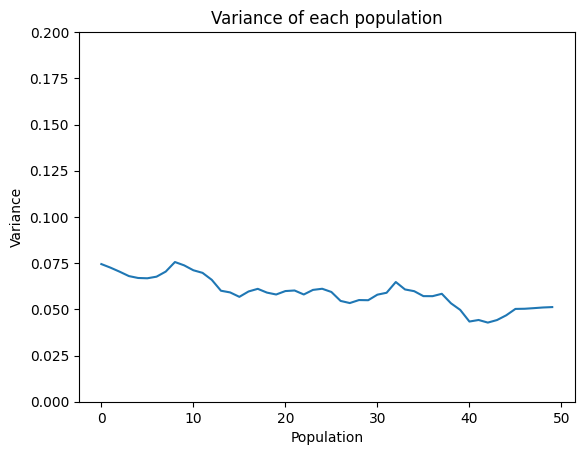

In [6]:
# plot variance
plt.plot(all_pops_cat)
plt.xlabel("Population")
plt.ylabel("Variance")
plt.title("Variance of each population")
plt.ylim(0, 0.2)
plt.savefig(f"output/{record_timestamp}/population_diversity.png")
plt.show()

## Categorical Diversity

In [7]:
with open("filenames.pkl", "rb") as f:
    df_filenames = pickle.load(f)
df_filenames.filename = df_filenames.filename.apply(os.path.splitext).str[0]

df_filenames.head()

,filename,sample_id
0,349217,0
1,399910,1
2,355149,2
3,35437,3
4,235105,4


In [8]:
# Load the metadata file

df_metacoll = pd.read_csv(
    r"D:\datasets\FSD50K\FSD50K.metadata\collection\collection_dev.csv"
)
df_metacoll.mids = df_metacoll.mids.str.split(",")
df_metacoll.fname = df_metacoll.fname.astype(str)

df_metacoll.head()

,fname,labels,mids
0,64760,Electric_guitar,[/m/02sgy]
1,16399,Electric_guitar,[/m/02sgy]
2,16401,Electric_guitar,[/m/02sgy]
3,16402,Electric_guitar,[/m/02sgy]
4,16404,Electric_guitar,[/m/02sgy]


In [58]:
df_iter_w_filename = df_iterations.merge(
    df_filenames, on="sample_id", how="left"
)
df_iter_w_filename.filename = df_iter_w_filename.filename.astype(str)

df_iter_w_filename.head()

ValueError: You are trying to merge on object and int64 columns for key 'sample_id'. If you wish to proceed you should use pd.concat

In [9]:
df_ontology_lookup = df_iter_w_filename.merge(
    df_metacoll, left_on="filename", right_on="fname", how="left"
)
df_ontology_lookup["mids_first"] = df_ontology_lookup.mids.str[0]

df_ontology_lookup.head()

NameError: name 'df_iter_w_filename' is not defined

In [11]:
all_pops_cat = []
for pop in df_ontology_lookup["pop"].unique():
    cats = df_ontology_lookup.loc[
        df_ontology_lookup["pop"] == pop, "mids_first"
    ]
    all_pops_cat.append(len(set(cats)) / len(cats))

np.array(all_pops_cat).shape

(50,)

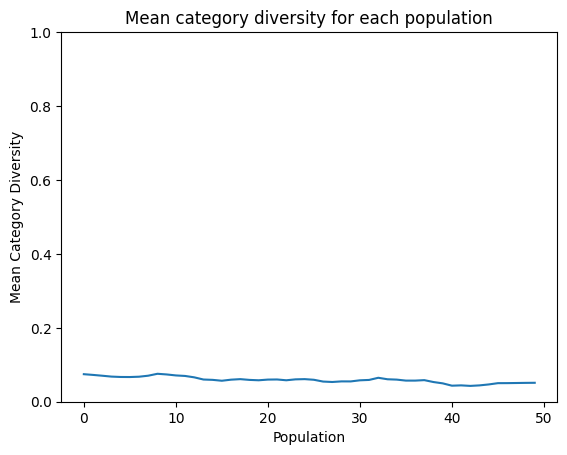

In [10]:
# plot

plt.clf()
plt.plot(all_pops_cat)
plt.xlabel("Population")
plt.ylabel("Mean Category Diversity")
plt.title("Mean category diversity for each population")
plt.ylim(0, 1)
plt.savefig(f"output/{record_timestamp}/category_diversity.png")
plt.show()

## Coverage of Dataset Categories/Samples

In [61]:
df_ontology_lookup.fname.unique().shape[0], df_metacoll.fname.astype(
    str
).unique().shape[0]

(210, 40966)

In [62]:
df_ontology_lookup.fname.unique().shape[0] / df_metacoll.fname.astype(
    str
).unique().shape[0] * 100, "percent"

(0.5126202216472197, 'percent')

## Phylogenetic
Graph operations

In [11]:
# load the graph to nx

with open(
    f"output/{record_timestamp}/{record_timestamp}_analysis_evo_graph.gpickle",
    "rb",
) as f:
    G = pickle.load(f)

G.number_of_nodes()

12074

In [12]:
# get copt of the graph

G_plot = G.copy()


G_plot.number_of_nodes()

12074

In [13]:
# make bidirectional
# by adding the reverse edges

for u, v in G_plot.edges():
    G_plot.add_edge(v, u)

G_plot.number_of_edges()

47420

## Visualize the Graph

In [68]:
# Interactive visualization
%matplotlib qt

In [69]:
# copy and optionally filter out for testing

G_filtered = G_plot.copy()

# filter out nodes
# G_filtered.remove_nodes_from(
#     [node[0] for node in G_plot.nodes(data=True) if node[1]["pop"] < 147]
# )

In [18]:
# Draw the graph multipartite

# get the positions multi-partite
pos = nx.multipartite_layout(G_filtered, subset_key="pop", align="horizontal")

# draw the graph
plt.clf()
nx.draw(
    G_filtered,
    pos,
    # labels=nx.get_node_attributes(G, "label"),
    # with_labels=True,
    node_size=75,
    font_size=10,
    font_weight="bold",
    arrowsize=8,
    width=1,
    alpha=0.75,
)

# add labels
for node in G_filtered.nodes():
    x, y = pos[node]
    label = node  # G.nodes[node]["sample_id"]  # [:20]
    plt.text(x, y, label, fontsize=12, rotation=45, ha="left")

plt.title("Evolutionary Graph")
plt.show()
plt.savefig(f"output/{record_timestamp}/evolutionary_graph.png")

KeyboardInterrupt: 

# Pairwise Distances

In [19]:
# get max population
max_pop = df_iterations["pop"].max()

max_pop

51

In [55]:
all_mpd_pops = []
all_pops_unique = (
    pd.Series([node[1]["pop"] for node in G_plot.nodes(data=True)])
    .sort_values()
    .unique()
)
for pop in [max_pop]:  # sorted(all_pops_unique):
    leaf_nodes = [n for n in G_plot.nodes(data=True) if n[1]["pop"] == pop]
    G_upto_pop = G_plot.subgraph(
        [n[0] for n in G_plot.nodes(data=True) if n[1]["pop"] <= pop]
    )

    # for each unique pair of leaf nodes,
    # calculate the shortest path between them
    pairwise_distances = {}
    no_path = []
    for i in range(len(leaf_nodes)):
        for j in range(i + 1, len(leaf_nodes)):
            try:
                dist = nx.shortest_path_length(
                    G_upto_pop, leaf_nodes[i][0], leaf_nodes[j][0]
                )
                if dist > 2:
                    pairwise_distances[(i, j)] = dist + 1
            except nx.NetworkXNoPath:
                no_path.append((i, j))
                # print(f"No path between {leaf_nodes[i][0]} and {leaf_nodes[j][0]}")

    pairwise_distances_values = np.array(list(pairwise_distances.values()))

    mpd_pop = (
        pairwise_distances_values.sum()
        * 2
        / (len(leaf_nodes) * (len(leaf_nodes) - 1))
    )
    all_mpd_pops.append(mpd_pop)
    print(
        f"Population {str(pop).zfill(3)} "
        f"Mean Pairwise Distances: {mpd_pop.round(2)} ",
    )

np.array(all_mpd_pops).shape, np.array(no_path).shape

Population 051 Mean Pairwise Distances: 6.55 


((1,), (0,))

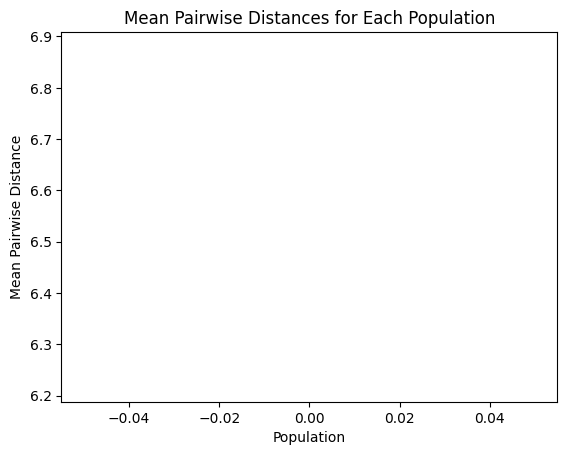

In [56]:
# plot

plt.clf()
plt.plot(all_mpd_pops)
plt.xlabel("Population")
plt.ylabel("Mean Pairwise Distance")
plt.title("Mean Pairwise Distances for Each Population")
plt.savefig(f"output/{record_timestamp}/mean_pairwise_distance.png")
plt.show()

In [62]:
final_mpd = all_mpd_pops[-1]

final_mpd

6.5483579154375615

# Root Contribution Index

In [54]:
"""
Root Contribution Index (RCI):} Calculates the \textbf{contribution of each root}
to the current population by counting the number of descendants for each root,
and scales it by the \textbf{age of the root} (in generations). Calculated for
each generation.
"""

# get the roots based on the condition that they have no incoming edges
roots = [n for n in G.nodes() if G.in_degree(n) == 0]

# calculate the number of leaves that they lead to, for each root
root_contributions = []
for root in roots:
    descs = nx.descendants(G, root)
    # leaf_descs = [n for n in descs if G.nodes[n]["pop"] == max_pop]
    root_age = max_pop - G.nodes[root]["pop"]
    contribution = len(descs) / root_age
    root_contributions.append(contribution)

root_contributions = np.array(root_contributions)
final_rci = root_contributions.sum() / G.number_of_nodes()

final_rci

1.4047970846446913

In [64]:
phylo_idx = final_mpd / final_rci

phylo_idx

4.661426185329682

# Other

In [396]:
#
# #
# #
# #
# #
#

In [ ]:
######## comment out

for iteration in df_iterations.iteration.unique()[:1]:
    df_epoch = df_iterations[df_iterations.iteration == iteration]
    df_epoch = df_epoch[["p1", "p2", "p3", "p4", "p5", "p6"]]

df_epoch

In [ ]:
# Scale the features
# scaler = StandardScaler()
# data_scaled = scaler.fit_transform(nd_features)

# Apply K-means clustering
kmeans = KMeans(n_clusters=5, random_state=42).fit(nd_features)
labels = kmeans.labels_

# Save the DataFrame with cluster labels
df_features["cluster"] = labels
with open("features_clustered_TEST.pkl", "wb") as f:
    pickle.dump(df_features, f)
###

# print(df_features.head())
# print(df_features.describe())
print(df_features.cluster.value_counts())

In [ ]:
#### comment out

# find visited indexes
visited_indexes = []
for individual in df_epoch.values:
    for index, feature in enumerate(nd_features):
        if np.array_equal(individual, feature):
            visited_indexes.append(index)
            break
visited_indexes = np.array(visited_indexes)

visited_indexes

In [9]:
# VISUALIZE THE CLUSTERS (2D) with t-SNE
tsne = TSNE(n_components=2, random_state=0)
features_data_tsne = tsne.fit_transform(nd_features)
df_tsne = pd.DataFrame(features_data_tsne, columns=["x", "y"])

output_dir = f"output/{record_timestamp}/clusters"
os.makedirs(output_dir, exist_ok=True)

figure_filenames = []
for i, iteration in enumerate(df_iterations.iteration.unique()[:10]):
    df_epoch = df_iterations[df_iterations.iteration == iteration]
    df_epoch = df_epoch[["p1", "p2", "p3", "p4", "p5", "p6"]]

    # find visited indexes
    visited_indexes = []
    for individual in df_epoch.values:
        for index, feature in enumerate(nd_features):
            if np.array_equal(individual, feature):
                visited_indexes.append(index)
                break
    visited_indexes = np.array(visited_indexes)

    df_tsne["cluster"] = labels

    plt.clf()
    plt.figure(figsize=(10, 10))
    plt.scatter(
        df_tsne["x"], df_tsne["y"], s=1, c=df_tsne["cluster"], cmap="viridis"
    )
    plt.scatter(
        df_tsne["x"].iloc[visited_indexes],
        df_tsne["y"].iloc[visited_indexes],
        c="red",
        s=3,
        marker="^",
    )
    # plt.show()

    output_file = os.path.join(output_dir, f"generation_{i}.png")
    plt.savefig(output_file)
    figure_filenames.append(output_file)

"end"

In [8]:
# make a gif

# Load each figure and append it to the images list
images = []
for filename in figure_filenames:
    image = Image.open(filename)
    images.append(image)

# Save the images as a GIF
output_filename = os.path.join(output_dir, "evolution_anim.gif")
imageio.mimsave(output_filename, images, duration=0.1)

# Remove the individual figure files
# for filename in figure_filenames:
#     os.remove(filename)

In [13]:
# VISUALIZE THE CLUSTERS (3D) with t-SNE
tsne = TSNE(n_components=3, random_state=0)
features_data_tsne = tsne.fit_transform(nd_features)

df_tsne = pd.DataFrame(features_data_tsne, columns=["x", "y", "z"])
df_tsne["cluster"] = labels

fig = plt.figure(figsize=(10, 10))
ax = fig.add_subplot(111, projection="3d")
ax.scatter(
    df_tsne["x"],
    df_tsne["y"],
    df_tsne["z"],
    c=df_tsne["cluster"],
    cmap="viridis",
)
plt.show()
plt.savefig("clusters_3d_TEST.png")